In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

TRAIN_SEASONS = list(range(2019, 2025))
PREDICT_SEASON = 2025
ELO_K = 20
ELO_HOME_ADV = 60
ROLLING_WINDOW = 5
RANDOM_STATE = 42

def init_elo(teams, base=1500):
    return {t: base for t in teams}

def expected_score(elo_ta, elo_th):
    return 1 / (1 + 10 ** ((elo_ta - elo_th) / 400.0))

def compute_elo_ratings(df):
    """
    Compute per-match pre-game ELO ratings for home and away teams.
    Returns two new columns: elo_home_pre, elo_away_pre
    """

    team_col_home='home_team'
    team_col_away='away_team'
    score_home='home_score'
    score_away='away_score'
    season_order_col='kickoff_datetime'

    teams = pd.concat([df[team_col_home], df[team_col_away]]).unique()
    elo = init_elo(teams)
    elo_home_pre = []
    elo_away_pre = []

    df_sorted = df.sort_values(by=season_order_col).reset_index(drop=True)
    for _, row in df_sorted.iterrows():
        th = row[team_col_home]
        ta = row[team_col_away]
        elo_home_pre.append(elo[th])
        elo_away_pre.append(elo[ta])

        # compute outcome
        if row[score_home] > row[score_away]:
            s_h, s_a = 1.0, 0.0
        elif row[score_home] < row[score_away]:
            s_h, s_a = 0.0, 1.0
        else:
            s_h, s_a = 0.5, 0.5

        exp_h = expected_score(elo[ta], elo[th])
        exp_a = 1-exp_h

        elo[th] = elo[th] + ELO_K * (s_h - exp_h)
        elo[ta] = elo[ta] + ELO_K * (s_a - exp_a)

    # attach to original index
    df_out = df_sorted.copy()
    df_out['elo_home_pre'] = elo_home_pre
    df_out['elo_away_pre'] = elo_away_pre
    return df_out.sort_index()  # put back in original order

def predict(df):

    df = df.rename(columns={ 'winner': 'winner_label', 'outcome': 'outcome_label' }) if 'winner' in df.columns else df

    df = compute_elo_ratings(df)

    df['home_adv'] = 1
    df['goal_diff_pre'] = df['elo_home_pre'] - df['elo_away_pre']

    home_rows = df[['match_id','kickoff_datetime','season','home_team','away_team','home_score','away_score']].copy()
    home_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    home_rows['is_home'] = 1
    away_rows = df[['match_id','kickoff_datetime','season','away_team','home_team','away_score','home_score']].copy()
    away_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    away_rows['is_home'] = 0
    team_rows = pd.concat([home_rows, away_rows], ignore_index=True)

    team_rows = team_rows.sort_values(['team','kickoff_datetime'])
    #compute rolling avg
    team_rows['points'] = team_rows.apply(lambda r: 3 if r['score_for']>r['score_against'] else (1 if r['score_for']==r['score_against'] else 0), axis=1)
    team_rows[['gf_roll','ga_roll','pts_roll']] = team_rows.groupby('team')[['score_for','score_against','points']].rolling(window=ROLLING_WINDOW, min_periods=1).mean().reset_index(level=0, drop=True)[['score_for','score_against','points']]

    # take last pre-match rolling values for home and away
    team_rows = team_rows.sort_values(['match_id','team','kickoff_datetime']).drop_duplicates(subset=['match_id','team'], keep='last')
    home_features = team_rows[team_rows['is_home']==1][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'home_{c}' if c!='match_id' else c)
    away_features = team_rows[team_rows['is_home']==0][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'away_{c}' if c!='match_id' else c)
    df = df.merge(home_features, on='match_id', how='left').merge(away_features, on='match_id', how='left')

    df = df.sort_values('kickoff_datetime').reset_index(drop=True)

    last_kickoff = {}
    rest_days_home = []
    rest_days_away = []
    for _, row in df.iterrows():
        th = row['home_team']; ta = row['away_team']; t0 = row['kickoff_datetime']

        if th in last_kickoff:
            delta = (t0 - last_kickoff[th]).total_seconds() / (24*3600)
            rest_days_home.append(delta)
        else:
            rest_days_home.append(np.nan)
        last_kickoff[th] = t0

        if ta in last_kickoff:
            delta = (t0 - last_kickoff[ta]).total_seconds() / (24*3600)
            rest_days_away.append(delta)
        else:
            rest_days_away.append(np.nan)
        last_kickoff[ta] = t0
    df['rest_days_home'] = rest_days_home
    df['rest_days_away'] = rest_days_away
    df['rest_days_diff'] = df['rest_days_home'] - df['rest_days_away']


    label_map = {'H_or_D':0,'A':1}
    df['target'] = df['outcome_label'].map(label_map)

    # Test is season 2025
    TRAIN_SEASONS = list(range(df['season'].min(), 2023))
    PREDICT_SEASON = list(range(2023,df['season'].max() +1))
    print(TRAIN_SEASONS, PREDICT_SEASON)
    train_df = df[df['season'].isin(TRAIN_SEASONS)].copy()
    test_df = df[df['season'].isin(PREDICT_SEASON)].copy()


    features = [
        'elo_home_pre','elo_away_pre','goal_diff_pre',
        'home_gf_roll','home_ga_roll','home_pts_roll',
        'away_gf_roll','away_ga_roll','away_pts_roll',
        'rest_days_home','rest_days_away','rest_days_diff'
    ]

    X_train = train_df[features]
    y_train = train_df['target']

    X_test = test_df[features]
    y_test = test_df['target']

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )

    rf_model.fit(X_train, y_train)
    #Predict with RandomForestClassifier the probability of H_or_D or A
    prob = rf_model.predict_proba(X_test)
    pred_labels = np.argmax(prob, axis=1)
    test_df[['prob_H_or_D','prob_A']] = prob
    inv_label = {v:k for k,v in label_map.items()}
    test_df['pred_outcome'] = [inv_label[l] for l in pred_labels]
    def pred_winner(row):
        if row['pred_outcome'] == 'H_or_D':
            return row['home_team']
        elif row['pred_outcome'] == 'A':
            return row['away_team']
        else:
            return 'Draw'
    test_df['pred_winner'] = test_df.apply(pred_winner, axis=1)

    #evaluate
    if 'target' in test_df.columns:
        print("Test logloss:", log_loss(y_test, prob))
        print("Test accuracy:", accuracy_score(y_test, pred_labels))
        print("Confusion matrix (rows true, cols pred):")
        print(confusion_matrix(y_test, pred_labels))
    #Save the results to a csv
    out_path = 'predictions_2025_matches.csv'
    test_df.to_csv(out_path, index=False)
    print(f"Predictions saved to {out_path}. Sample:")
    print(test_df[['match_id','kickoff_datetime','home_team','away_team','prob_H_or_D','prob_A','pred_outcome','pred_winner']].head(10))

    #plot the most important features
    importances = rf_model.feature_importances_
    feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_importance.values, y=feat_importance.index)
    plt.title("Feature Importance")
    plt.show()

In [3]:
import data_loader as dl
import importlib
importlib.reload(dl)
m,s = dl.load_data()
m


✓ Successfully loaded 3889 matches from matchweeks 1-38

Sample data:
   matchweek                 home_team         away_team  home_score  \
0          1                 Liverpool       Bournemouth           4   
1          1               Aston Villa  Newcastle United           0   
2          1  Brighton and Hove Albion            Fulham           1   
3          1         Nottingham Forest         Brentford           3   
4          1                Sunderland   West Ham United           3   

   away_score outcome  
0           2  H_or_D  
1           0  H_or_D  
2           1  H_or_D  
3           1  H_or_D  
4           0  H_or_D  

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889 entries, 0 to 3888
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   match_id              3889 non-null   object        
 1   matchweek             3889 non-null   int64   

,match_id,matchweek,season,kickoff,kickoff_timezone,period,competition,venue,attendance,clock,...,home_red_cards,away_team,away_team_id,away_team_short,away_score,away_half_time_score,away_red_cards,outcome,winner,kickoff_datetime
0,2561895,1,2025,2025-08-15 20:00:00,BST,FullTime,Premier League,"Anfield, Liverpool",60315.0,97,...,0.0,Bournemouth,91,Bournemouth,2,0,0.0,H_or_D,Liverpool,2025-08-15 20:00:00
1,2561896,1,2025,2025-08-16 12:30:00,BST,FullTime,Premier League,"Villa Park, Birmingham",42526.0,97,...,1.0,Newcastle United,4,Newcastle,0,0,0.0,H_or_D,Draw,2025-08-16 12:30:00
2,2561897,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"American Express Stadium, Falmer",31478.0,98,...,0.0,Fulham,54,Fulham,1,0,0.0,H_or_D,Draw,2025-08-16 15:00:00
3,2561898,1,2025,2025-08-17 14:00:00,BST,FullTime,Premier League,"The City Ground, Nottingham",29949.0,96,...,0.0,Brentford,94,Brentford,1,0,0.0,H_or_D,Nottingham Forest,2025-08-17 14:00:00
4,2561899,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"Stadium of Light, Sunderland",46233.0,98,...,0.0,West Ham United,21,West Ham,0,0,0.0,H_or_D,Sunderland,2025-08-16 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,803537,38,2015,2016-05-15 15:00:00,BST,FullTime,Premier League,"Swansea.com Stadium, Swansea",20934.0,94,...,0.0,Manchester City,43,Man City,1,1,0.0,H_or_D,Draw,2016-05-15 15:00:00
3885,803538,38,2015,2016-05-15 15:00:00,BST,FullTime,Premier League,"Goodison Park, Liverpool",36691.0,93,...,0.0,Norwich City,45,Norwich,0,0,0.0,H_or_D,Everton,2016-05-15 15:00:00
3886,803539,38,2015,2016-05-15 15:00:00,BST,FullTime,Premier League,"Vicarage Road, Watford",21012.0,95,...,0.0,Sunderland,56,Sunderland,2,1,0.0,H_or_D,Draw,2016-05-15 15:00:00
3887,803540,38,2015,2016-05-15 15:00:00,BST,FullTime,Premier League,"St. James' Park, Newcastle",52183.0,94,...,1.0,Tottenham Hotspur,6,Spurs,1,0,0.0,H_or_D,Newcastle United,2016-05-15 15:00:00


[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022] [2023, 2024, 2025]
Test logloss: 0.4075744534218737
Test accuracy: 0.8138987043580683
Confusion matrix (rows true, cols pred):
[[517  51]
 [107 174]]
Predictions saved to predictions_2025_matches.csv. Sample:
     match_id    kickoff_datetime                 home_team  \
3040  2367538 2023-08-11 20:00:00                   Burnley   
3041  2367540 2023-08-12 13:00:00                   Arsenal   
3042  2367542 2023-08-12 15:00:00                   Everton   
3043  2367544 2023-08-12 15:00:00          Sheffield United   
3044  2367539 2023-08-12 15:00:00               Bournemouth   
3045  2367541 2023-08-12 15:00:00  Brighton and Hove Albion   
3046  2367543 2023-08-12 17:30:00          Newcastle United   
3047  2367545 2023-08-13 14:00:00                 Brentford   
3048  2367546 2023-08-13 16:30:00                   Chelsea   
3049  2367547 2023-08-14 20:00:00         Manchester United   

                    away_team  prob_H_or_D  prob

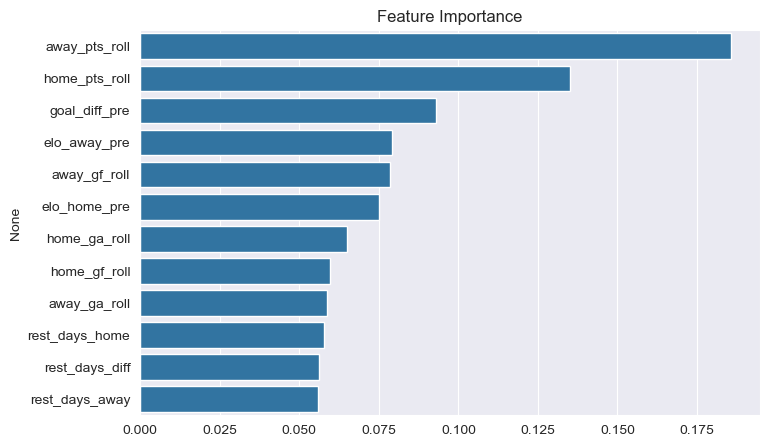

In [6]:
predict(m)